In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data65


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 11.7MB/s eta 0:00:01


In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
#加载飞桨和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
from paddle.vision.transforms import Compose, Normalize

transform = Compose([Normalize(mean=[127.5],
                               std=[127.5],
                               data_format='CHW')])
# 使用transform对数据集做归一化
print('download training data and load training data')
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('load finished')

download training data and load training data


Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


load finished


train_data0 label is: [5]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

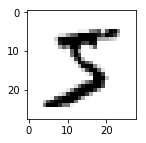

In [3]:
import numpy as np
import matplotlib.pyplot as plt
train_data0, train_label_0 = train_dataset[0][0],train_dataset[0][1]
train_data0 = train_data0.reshape([28,28])
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
print('train_data0 label is: ' + str(train_label_0))

In [4]:
class ResidualBlock(paddle.nn.Layer):
    def __init__(self, inchannel, outchannel, stride):
        super(ResidualBlock, self).__init__()
        self.left = paddle.nn.Sequential(
            paddle.nn.Conv2D(inchannel, outchannel, kernel_size=3, stride=stride, padding=1),
            paddle.nn.BatchNorm2D(outchannel),
            paddle.nn.ReLU(),
            paddle.nn.Conv2D(outchannel, outchannel, kernel_size=3, stride=1, padding=1),
            paddle.nn.BatchNorm2D(outchannel)
        )
        self.shortcut = paddle.nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = paddle.nn.Sequential(
                paddle.nn.Conv2D(inchannel, outchannel, kernel_size=1, stride=stride),
                paddle.nn.BatchNorm2D(outchannel)
            )
 
    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
class ResNet(paddle.nn.Layer):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = paddle.nn.Sequential(
            paddle.nn.Conv2D(1, 64, kernel_size=3, stride=1, padding=1,),
            paddle.nn.BatchNorm2D(64),
            paddle.nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = paddle.nn.Linear(512, num_classes)
 
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        print(strides)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return paddle.nn.Sequential(*layers)
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out,4)
        flatten = paddle.nn.Flatten()
        out = flatten(out)
        out = self.fc(out)
        return out


In [6]:
def ResNet18():
 
    return ResNet(ResidualBlock)


In [7]:
import paddle.nn.functional as F
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)
# 加载训练集 batch_size 设为 64
def train(model):
    model.train()
    epochs = 2
    optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    # 用Adam作为优化函数
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = F.cross_entropy(predicts, y_data)
            # 计算损失
            acc = paddle.metric.accuracy(predicts, y_data)
            loss.backward()
            if batch_id % 300 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
            optim.step()
            optim.clear_grad()
model = ResNet18()
train(model)

[1, 1]
[2, 1]
[2, 1]
[2, 1]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


epoch: 0, batch_id: 0, loss is: [2.3766313], acc is: [0.125]
epoch: 0, batch_id: 300, loss is: [0.05624298], acc is: [0.984375]
epoch: 0, batch_id: 600, loss is: [0.07799084], acc is: [0.96875]
epoch: 0, batch_id: 900, loss is: [0.0218874], acc is: [1.]
epoch: 1, batch_id: 0, loss is: [0.02034235], acc is: [0.984375]
epoch: 1, batch_id: 300, loss is: [0.03891412], acc is: [0.984375]
epoch: 1, batch_id: 600, loss is: [0.0013164], acc is: [1.]
epoch: 1, batch_id: 900, loss is: [0.19440255], acc is: [0.96875]


In [ ]:
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载测试数据集
def test(model):
    model.eval()
    batch_size = 64
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = F.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        if batch_id % 20 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))
test(model)

batch_id: 0, loss is: [0.00521052], acc is: [1.]
batch_id: 20, loss is: [0.02938455], acc is: [0.984375]
batch_id: 40, loss is: [0.03940312], acc is: [0.984375]
batch_id: 60, loss is: [0.01027248], acc is: [1.]
batch_id: 80, loss is: [0.02612897], acc is: [1.]
